


# Прогнозирование оттока клиентов

## Описание проекта
Оператор связи «Ниединогоразрыва.ком» хочет научиться прогнозировать отток клиентов. Если выяснится, что пользователь планирует уйти, ему будут предложены промокоды и специальные условия. Команда оператора собрала персональные данные о некоторых клиентах, информацию об их тарифах и договорах.

---

<h2>Содержание</h2>

<div class="toc">
  <ul>
    <li><a href="#Описание-проекта">Описание проекта</a></li>
    <li><a href="#Предварительный-обзор-данных">Предварительный обзор данных</a></li>
      <ul>
        <li><a href="#Информация-о-договоре">Информация о договоре</a></li>
        <li><a href="#Персональные-данные-клиента">Персональные данные клиента</a></li>
        <li><a href="#Информация-об-интернет-услугах">Информация об интернет-услугах</a></li>
        <li><a href="#Информация-об-услугах-телефонии">Информация об услугах телефонии</a></li>
      </ul>
    <li><a href="#План-работы">План работы</a></li>
    <li><a href="#Предобработка-данных">Предобработка данных</a></li>
    <li><a href="#Анализ-данных">Анализ данных</a></li>
    <li><a href="#Обучение-моделей">Обучение моделей</a></li>
    <li><a href="#Тестирование-модели">Тестирование модели</a></li>
       <ul>
        <li><a href="#Анализ-важности-признаков">Анализ важности признаков</a></li>
        <li><a href="#Анализ-матрицы-ошибок">Анализ матрицы ошибок</a></li>
      </ul>
    <li><a href="#Вывод-по-итогам-работы">Вывод по итогам работы</a></li>
  </ul>
</div>

<style>
  .toc ul {
    font-size: 14px;
  }
</style>

---
### Цели и задачи

**Цель** - построить модель, которая будет эффективно предсказывать отток клиентов.

**Задачи**:
    
    1. Загрузить и осмотреть данные.  
    2. Предобработать данные.
    3. Провести исследовательский анализ.
    4. Подготовить данные для обучения моделей.
    5. Обучение моделей и тестирование лучшей.
    6. Сделать выводы по итогам работы.
---
    
### Описание данных

Данные состоят из файлов, полученных из разных источников:

- `contract_new.csv` — информация о договоре;
- `personal_new.csv` — персональные данные клиента;
- `internet_new.csv` — информация об интернет-услугах;
- `phone_new.csv` — информация об услугах телефонии.

### Описание полей данных

- `BeginDate` – дата начала пользования услугами.
- `EndDate` – дата окончания пользования услугами.
- `Type` – тип оплаты: ежемесячный, годовой и тд.
- `PaperlessBilling` – безналичный расчет.
- `PaymentMethod` – способ оплаты.
- `MonthlyCharges` – ежемесячные траты на услуги.
- `TotalCharges` – всего потрачено денег на услуги.
- `Dependents` – наличие иждивенцев.
- `Senior Citizen` – наличие пенсионного статуса по возрасту.
- `Partner` – наличие супруга(и).
- `MultipleLines` – наличие возможности ведения параллельных линий во время звонка.

Во всех файлах столбец `customerID` содержит код клиента.

Информация о договорах актуальна на 1 февраля 2020.

---

## Предварительный обзор данных

In [1]:
import os
import pandas as pd
import phik
from phik import resources, report
import seaborn as sns
import matplotlib.pyplot as plt

from catboost import CatBoostClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.preprocessing import OneHotEncoder, StandardScaler
from sklearn.compose import make_column_transformer
from sklearn.pipeline import Pipeline 
from sklearn.metrics import roc_auc_score, accuracy_score, roc_curve, confusion_matrix, precision_score, recall_score, f1_score

from tqdm import tqdm
import time
import warnings
warnings.filterwarnings('ignore')

In [2]:
RANDOM_STATE=80523

In [3]:
path1 = 'C:/Users/Dell/Desktop/Data_YP/Data/data_telecom/'
path2 = '/datasets/'

if os.path.exists(path1):
    df_contract = pd.read_csv(os.path.join(path1, 'contract_new.csv')) # информация о договоре;
    df_internet = pd.read_csv(os.path.join(path1, 'internet_new.csv')) # персональные данные клиента;
    df_personal = pd.read_csv(os.path.join(path1, 'personal_new.csv')) # информация об интернет-услугах;
    df_phone = pd.read_csv(os.path.join(path1, 'phone_new.csv')) # информация об услугах телефонии.
else:
    df_contract = pd.read_csv(os.path.join(path2, 'contract_new.csv')) # информация о договоре;
    df_internet = pd.read_csv(os.path.join(path2, 'internet_new.csv')) # персональные данные клиента;
    df_personal = pd.read_csv(os.path.join(path2, 'personal_new.csv')) # информация об интернет-услугах;
    df_phone = pd.read_csv(os.path.join(path2, 'phone_new.csv')) # информация об услугах телефонии.

In [4]:
def df_info(data):# обзорная функция
    data.info()
    display(data.head())
    display(data.describe())
    print('\nЧисло дубликатов:', data.duplicated().sum())

In [5]:
def df_unique_search(data): # функция для поиска уникальных и нестандартных значений в данных    
    for column in data.columns:
        print('Уникальные значения столбца:', column)
        try:
            df_sort = data[column].value_counts()
            df_sort.sort()
            print(df_sort)
        except:
            print(data[column].value_counts())
        print('--------------------------------------------------')

### Информация о договоре

In [6]:
df_info(df_contract)

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 7043 entries, 0 to 7042
Data columns (total 8 columns):
 #   Column            Non-Null Count  Dtype  
---  ------            --------------  -----  
 0   customerID        7043 non-null   object 
 1   BeginDate         7043 non-null   object 
 2   EndDate           7043 non-null   object 
 3   Type              7043 non-null   object 
 4   PaperlessBilling  7043 non-null   object 
 5   PaymentMethod     7043 non-null   object 
 6   MonthlyCharges    7043 non-null   float64
 7   TotalCharges      7043 non-null   object 
dtypes: float64(1), object(7)
memory usage: 440.3+ KB


,customerID,BeginDate,EndDate,Type,PaperlessBilling,PaymentMethod,MonthlyCharges,TotalCharges
0,7590-VHVEG,2020-01-01,No,Month-to-month,Yes,Electronic check,29.85,31.04
1,5575-GNVDE,2017-04-01,No,One year,No,Mailed check,56.95,2071.84
2,3668-QPYBK,2019-10-01,No,Month-to-month,Yes,Mailed check,53.85,226.17
3,7795-CFOCW,2016-05-01,No,One year,No,Bank transfer (automatic),42.30,1960.6
4,9237-HQITU,2019-09-01,No,Month-to-month,Yes,Electronic check,70.70,353.5


,MonthlyCharges
count,7043.000000
mean,64.761692
std,30.090047
min,18.250000
25%,35.500000
50%,70.350000
75%,89.850000
max,118.750000



Число дубликатов: 0


In [7]:
df_unique_search(df_contract)

Уникальные значения столбца: customerID
8007-YYPWD    1
7328-ZJAJO    1
2676-OXPPQ    1
5533-NHFRF    1
5035-PGZXH    1
             ..
3834-XUIFC    1
8878-HMWBV    1
6463-HHXJR    1
6791-YBNAK    1
3537-HPKQT    1
Name: customerID, Length: 7043, dtype: int64
--------------------------------------------------
Уникальные значения столбца: BeginDate
2014-02-01    366
2019-10-01    237
2019-09-01    237
2019-11-01    237
2020-01-01    233
             ... 
2020-02-01     11
2014-01-01      7
2013-12-01      3
2013-10-01      3
2013-11-01      2
Name: BeginDate, Length: 77, dtype: int64
--------------------------------------------------
Уникальные значения столбца: EndDate
No            5942
2020-01-01      39
2019-12-01      38
2018-11-01      35
2019-09-01      32
              ... 
2014-12-01       2
2015-04-01       2
2014-11-01       1
2014-10-01       1
2014-06-01       1
Name: EndDate, Length: 67, dtype: int64
--------------------------------------------------
Уникальные значения с

#### Вывод по `df_contract`:
    
* `BeginDate` и `EndDate` нужно перевести в формат даты.
* В `EndDate` есть значение `No` - означающее, что клиент продолжает пользоваться услугами. Нужно сформировать Целевой признак из столбца `EndDate`, а значение `No` заменить на `2020-02-01`.
* В `TotalCharges` есть неявные пропуски с пустым значением. Заполним пустые значения соответствующим значением из столбца `MonthlyCharges` и приведем его в числовой тип.
* Остальные категориальные признаками нужно закодировать.

### Персональные данные клиента

In [8]:
df_info(df_internet)

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 5517 entries, 0 to 5516
Data columns (total 8 columns):
 #   Column            Non-Null Count  Dtype 
---  ------            --------------  ----- 
 0   customerID        5517 non-null   object
 1   InternetService   5517 non-null   object
 2   OnlineSecurity    5517 non-null   object
 3   OnlineBackup      5517 non-null   object
 4   DeviceProtection  5517 non-null   object
 5   TechSupport       5517 non-null   object
 6   StreamingTV       5517 non-null   object
 7   StreamingMovies   5517 non-null   object
dtypes: object(8)
memory usage: 344.9+ KB


,customerID,InternetService,OnlineSecurity,OnlineBackup,DeviceProtection,TechSupport,StreamingTV,StreamingMovies
0,7590-VHVEG,DSL,No,Yes,No,No,No,No
1,5575-GNVDE,DSL,Yes,No,Yes,No,No,No
2,3668-QPYBK,DSL,Yes,Yes,No,No,No,No
3,7795-CFOCW,DSL,Yes,No,Yes,Yes,No,No
4,9237-HQITU,Fiber optic,No,No,No,No,No,No


,customerID,InternetService,OnlineSecurity,OnlineBackup,DeviceProtection,TechSupport,StreamingTV,StreamingMovies
count,5517,5517,5517,5517,5517,5517,5517,5517
unique,5517,2,2,2,2,2,2,2
top,3926-CUQZX,Fiber optic,No,No,No,No,No,No
freq,1,3096,3498,3088,3095,3473,2810,2785



Число дубликатов: 0


In [9]:
df_unique_search(df_internet)

Уникальные значения столбца: customerID
3926-CUQZX    1
3987-KQDDU    1
6022-KOUQO    1
1049-FYSYG    1
1113-IUJYX    1
             ..
1251-KRREG    1
3714-XPXBW    1
1506-YJTYT    1
7134-MJPDY    1
3537-HPKQT    1
Name: customerID, Length: 5517, dtype: int64
--------------------------------------------------
Уникальные значения столбца: InternetService
Fiber optic    3096
DSL            2421
Name: InternetService, dtype: int64
--------------------------------------------------
Уникальные значения столбца: OnlineSecurity
No     3498
Yes    2019
Name: OnlineSecurity, dtype: int64
--------------------------------------------------
Уникальные значения столбца: OnlineBackup
No     3088
Yes    2429
Name: OnlineBackup, dtype: int64
--------------------------------------------------
Уникальные значения столбца: DeviceProtection
No     3095
Yes    2422
Name: DeviceProtection, dtype: int64
--------------------------------------------------
Уникальные значения столбца: TechSupport
No     3473
Y

#### Вывод по `df_internet`:
* В данных нет пропусков и явных дубликатов.
* Все категориальные признаки являются бинарными признаками.
* Есть данные не по всем клиентам.

### Информация об интернет-услугах

In [10]:
df_info(df_personal)

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 7043 entries, 0 to 7042
Data columns (total 5 columns):
 #   Column         Non-Null Count  Dtype 
---  ------         --------------  ----- 
 0   customerID     7043 non-null   object
 1   gender         7043 non-null   object
 2   SeniorCitizen  7043 non-null   int64 
 3   Partner        7043 non-null   object
 4   Dependents     7043 non-null   object
dtypes: int64(1), object(4)
memory usage: 275.2+ KB


,customerID,gender,SeniorCitizen,Partner,Dependents
0,7590-VHVEG,Female,0,Yes,No
1,5575-GNVDE,Male,0,No,No
2,3668-QPYBK,Male,0,No,No
3,7795-CFOCW,Male,0,No,No
4,9237-HQITU,Female,0,No,No


,SeniorCitizen
count,7043.000000
mean,0.162147
std,0.368612
min,0.000000
25%,0.000000
50%,0.000000
75%,0.000000
max,1.000000



Число дубликатов: 0


In [11]:
df_unique_search(df_personal)

Уникальные значения столбца: customerID
8007-YYPWD    1
7328-ZJAJO    1
2676-OXPPQ    1
5533-NHFRF    1
5035-PGZXH    1
             ..
3834-XUIFC    1
8878-HMWBV    1
6463-HHXJR    1
6791-YBNAK    1
3537-HPKQT    1
Name: customerID, Length: 7043, dtype: int64
--------------------------------------------------
Уникальные значения столбца: gender
Male      3555
Female    3488
Name: gender, dtype: int64
--------------------------------------------------
Уникальные значения столбца: SeniorCitizen
0    5901
1    1142
Name: SeniorCitizen, dtype: int64
--------------------------------------------------
Уникальные значения столбца: Partner
No     3641
Yes    3402
Name: Partner, dtype: int64
--------------------------------------------------
Уникальные значения столбца: Dependents
No     4933
Yes    2110
Name: Dependents, dtype: int64
--------------------------------------------------


#### Вывод по `df_personal`:
* В данных нет пропусков и явных дубликатов.
* Все категориальные признаки являются бинарными признаками. 

### Информация об услугах телефонии

In [12]:
df_info(df_phone)

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 6361 entries, 0 to 6360
Data columns (total 2 columns):
 #   Column         Non-Null Count  Dtype 
---  ------         --------------  ----- 
 0   customerID     6361 non-null   object
 1   MultipleLines  6361 non-null   object
dtypes: object(2)
memory usage: 99.5+ KB


,customerID,MultipleLines
0,5575-GNVDE,No
1,3668-QPYBK,No
2,9237-HQITU,No
3,9305-CDSKC,Yes
4,1452-KIOVK,Yes


,customerID,MultipleLines
count,6361,6361
unique,6361,2
top,8007-YYPWD,No
freq,1,3390



Число дубликатов: 0


In [13]:
df_unique_search(df_phone)

Уникальные значения столбца: customerID
8007-YYPWD    1
4003-FUSHP    1
8337-MSSXB    1
6620-HVDUJ    1
7025-WCBNE    1
             ..
2509-TFPJU    1
6121-VZNQB    1
4680-KUTAJ    1
3223-WZWJM    1
3537-HPKQT    1
Name: customerID, Length: 6361, dtype: int64
--------------------------------------------------
Уникальные значения столбца: MultipleLines
No     3390
Yes    2971
Name: MultipleLines, dtype: int64
--------------------------------------------------


#### Вывод по `df_phone`:
* В данных нет пропусков и явных дубликатов.
* Категориальный признак является бинарным признакам.
* Есть данные не по всем клиентам.

### Общий вывод по загруженным данным:
* Явные пропуски и дубликаты не найдены.
* Всего в выборке представлены договоры с `7043` клиентами, из которых пользователей интернета - `5517`, пользователей телефона - `6361`.

#### Проблемы в данных:
* Привести все столбцы во всех таблицах к нижнему регистру.
* `BeginDate` нужно перевести в формат даты.
* В `EndDate` нужно достать целевой признак и тоже перевести в формат даты. 
* Сформировать целевой признак из `EndDate` со значением `No` - означающее, что клиент продолжает пользоваться услугами.
* В `TotalCharges` заполнить пустые значения соответствующим значением из столбца `MonthlyCharges` и перевести его в числовой формат.
* Категориальные признаки закодировать.

---

## План работы

1) Описание проекта, задачи:
    
    - Описание задачи.
    - Описание данных.

2) Изучение и подготовка данных:

    - Загрузить данные.
    - Предварительно изучить полученные данные.

3) Предобработка данных:

    - Обработка пропусков и типов данных.
    - Создание целевого признака.
    - Подготовить итоговую таблицу со всеми признаками.

4) Анализ данных:

    - Анализ распределения признаков.
    - Исследование корреляции.
    - Оценка дисбаланса
    
5) Обучение моделей:

    - Формирование выборок.
    - Кодирование категориальных признаков.
    - Обучение и исследование моделей.
    - Оценка моделей на кросс-валидации.

6) Тестирование модели:

    - Оценка лучшей модели на тестовой выборке.
    - Анализ важности признаков.
    - Анализ матрицы ошибок.

7) Вывод по итогам работы.

---

## Предобработка данных

In [14]:
# приведение названий столбцов к нижнему регистру
def lowercase_columns(df):
    df.columns = df.columns.str.lower()
    return df

dfs = [df_contract, df_internet, df_personal, df_phone]

for i in range(len(dfs)):
    dfs[i] = lowercase_columns(dfs[i])
    print(dfs[i].info())

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 7043 entries, 0 to 7042
Data columns (total 8 columns):
 #   Column            Non-Null Count  Dtype  
---  ------            --------------  -----  
 0   customerid        7043 non-null   object 
 1   begindate         7043 non-null   object 
 2   enddate           7043 non-null   object 
 3   type              7043 non-null   object 
 4   paperlessbilling  7043 non-null   object 
 5   paymentmethod     7043 non-null   object 
 6   monthlycharges    7043 non-null   float64
 7   totalcharges      7043 non-null   object 
dtypes: float64(1), object(7)
memory usage: 440.3+ KB
None
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 5517 entries, 0 to 5516
Data columns (total 8 columns):
 #   Column            Non-Null Count  Dtype 
---  ------            --------------  ----- 
 0   customerid        5517 non-null   object
 1   internetservice   5517 non-null   object
 2   onlinesecurity    5517 non-null   object
 3   onlinebackup      5517 n

In [15]:
# Создание целевого признака
df_contract['escape'] = (df_contract['enddate'] != 'No').astype(int)
df_contract.head(10)

,customerid,begindate,enddate,type,paperlessbilling,paymentmethod,monthlycharges,totalcharges,escape
0,7590-VHVEG,2020-01-01,No,Month-to-month,Yes,Electronic check,29.85,31.04,0
1,5575-GNVDE,2017-04-01,No,One year,No,Mailed check,56.95,2071.84,0
2,3668-QPYBK,2019-10-01,No,Month-to-month,Yes,Mailed check,53.85,226.17,0
3,7795-CFOCW,2016-05-01,No,One year,No,Bank transfer (automatic),42.30,1960.6,0
4,9237-HQITU,2019-09-01,No,Month-to-month,Yes,Electronic check,70.70,353.5,0
5,9305-CDSKC,2019-03-01,No,Month-to-month,Yes,Electronic check,99.65,1150.96,0
6,1452-KIOVK,2018-04-01,No,Month-to-month,Yes,Credit card (automatic),89.10,2058.21,0
7,6713-OKOMC,2019-04-01,No,Month-to-month,No,Mailed check,29.75,300.48,0
8,7892-POOKP,2017-07-01,No,Month-to-month,Yes,Electronic check,104.80,3573.68,0
9,6388-TABGU,2014-12-01,2017-05-01,One year,No,Bank transfer (automatic),56.15,1628.35,1


In [16]:
# заполняем в `enddate` значение `No` на 2020-02-01
df_contract['enddate'] = df_contract['enddate'].replace(['No'], ['2020-02-01'])

# перевод столбцов `begindate` и `enddate` в формат datetime
df_contract['begindate'] = pd.to_datetime(df_contract['begindate'], format='%Y-%m-%d')
df_contract['enddate'] = pd.to_datetime(df_contract['enddate'], format='%Y-%m-%d')
df_contract.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 7043 entries, 0 to 7042
Data columns (total 9 columns):
 #   Column            Non-Null Count  Dtype         
---  ------            --------------  -----         
 0   customerid        7043 non-null   object        
 1   begindate         7043 non-null   datetime64[ns]
 2   enddate           7043 non-null   datetime64[ns]
 3   type              7043 non-null   object        
 4   paperlessbilling  7043 non-null   object        
 5   paymentmethod     7043 non-null   object        
 6   monthlycharges    7043 non-null   float64       
 7   totalcharges      7043 non-null   object        
 8   escape            7043 non-null   int32         
dtypes: datetime64[ns](2), float64(1), int32(1), object(5)
memory usage: 467.8+ KB


In [17]:
# разбираемся с проблемами столбца totalcharges
df_contract['totalcharges'] = pd.to_numeric(df_contract['totalcharges'], errors='coerce')
df_contract.info()
df_contract[df_contract['totalcharges'].isnull()]

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 7043 entries, 0 to 7042
Data columns (total 9 columns):
 #   Column            Non-Null Count  Dtype         
---  ------            --------------  -----         
 0   customerid        7043 non-null   object        
 1   begindate         7043 non-null   datetime64[ns]
 2   enddate           7043 non-null   datetime64[ns]
 3   type              7043 non-null   object        
 4   paperlessbilling  7043 non-null   object        
 5   paymentmethod     7043 non-null   object        
 6   monthlycharges    7043 non-null   float64       
 7   totalcharges      7032 non-null   float64       
 8   escape            7043 non-null   int32         
dtypes: datetime64[ns](2), float64(2), int32(1), object(4)
memory usage: 467.8+ KB


,customerid,begindate,enddate,type,paperlessbilling,paymentmethod,monthlycharges,totalcharges,escape
488,4472-LVYGI,2020-02-01,2020-02-01,Two year,Yes,Bank transfer (automatic),52.55,NaN,0
753,3115-CZMZD,2020-02-01,2020-02-01,Two year,No,Mailed check,20.25,NaN,0
936,5709-LVOEQ,2020-02-01,2020-02-01,Two year,No,Mailed check,80.85,NaN,0
1082,4367-NUYAO,2020-02-01,2020-02-01,Two year,No,Mailed check,25.75,NaN,0
1340,1371-DWPAZ,2020-02-01,2020-02-01,Two year,No,Credit card (automatic),56.05,NaN,0
3331,7644-OMVMY,2020-02-01,2020-02-01,Two year,No,Mailed check,19.85,NaN,0
3826,3213-VVOLG,2020-02-01,2020-02-01,Two year,No,Mailed check,25.35,NaN,0
4380,2520-SGTTA,2020-02-01,2020-02-01,Two year,No,Mailed check,20.00,NaN,0
5218,2923-ARZLG,2020-02-01,2020-02-01,One year,Yes,Mailed check,19.70,NaN,0
6670,4075-WKNIU,2020-02-01,2020-02-01,Two year,No,Mailed check,73.35,NaN,0


Так как эти пользователи только стали клиентами, заполним их пропуски соответствующими значениями из столбца `monthlycharges`, вероятно они внесли соответствующую оплату.

In [18]:
df_contract['totalcharges'] = df_contract['totalcharges'].fillna(df_contract['monthlycharges'])
df_contract['totalcharges'].isnull().sum()

0

In [19]:
# Общая таблица
df_telecom = df_contract.set_index('customerid') \
    .join(df_phone.set_index('customerid')) \
    .join(df_personal.set_index('customerid')) \
    .join(df_internet.set_index('customerid'))

df_telecom.info()

<class 'pandas.core.frame.DataFrame'>
Index: 7043 entries, 7590-VHVEG to 3186-AJIEK
Data columns (total 20 columns):
 #   Column            Non-Null Count  Dtype         
---  ------            --------------  -----         
 0   begindate         7043 non-null   datetime64[ns]
 1   enddate           7043 non-null   datetime64[ns]
 2   type              7043 non-null   object        
 3   paperlessbilling  7043 non-null   object        
 4   paymentmethod     7043 non-null   object        
 5   monthlycharges    7043 non-null   float64       
 6   totalcharges      7043 non-null   float64       
 7   escape            7043 non-null   int32         
 8   multiplelines     6361 non-null   object        
 9   gender            7043 non-null   object        
 10  seniorcitizen     7043 non-null   int64         
 11  partner           7043 non-null   object        
 12  dependents        7043 non-null   object        
 13  internetservice   5517 non-null   object        
 14  onlinesecurity

Пропуски, как мы уже знаем, это услуги, которыми клиенты не пользуются. Заполним пропуски значением `No`.

In [20]:
df_telecom = df_telecom.fillna('No')
df_telecom.info()

<class 'pandas.core.frame.DataFrame'>
Index: 7043 entries, 7590-VHVEG to 3186-AJIEK
Data columns (total 20 columns):
 #   Column            Non-Null Count  Dtype         
---  ------            --------------  -----         
 0   begindate         7043 non-null   datetime64[ns]
 1   enddate           7043 non-null   datetime64[ns]
 2   type              7043 non-null   object        
 3   paperlessbilling  7043 non-null   object        
 4   paymentmethod     7043 non-null   object        
 5   monthlycharges    7043 non-null   float64       
 6   totalcharges      7043 non-null   float64       
 7   escape            7043 non-null   int32         
 8   multiplelines     7043 non-null   object        
 9   gender            7043 non-null   object        
 10  seniorcitizen     7043 non-null   int64         
 11  partner           7043 non-null   object        
 12  dependents        7043 non-null   object        
 13  internetservice   7043 non-null   object        
 14  onlinesecurity

Из Столбцов `begindate` и `enddate` создадим отдельный признак `totaldays`, так как из `enddate` происходит утечка в целевой признак. После анализа столбцы с датой удалим.

In [21]:
df_telecom['totaldays'] = df_telecom.apply(lambda row: (row['enddate'] - row['begindate']).days, axis=1)
df_telecom.info()

<class 'pandas.core.frame.DataFrame'>
Index: 7043 entries, 7590-VHVEG to 3186-AJIEK
Data columns (total 21 columns):
 #   Column            Non-Null Count  Dtype         
---  ------            --------------  -----         
 0   begindate         7043 non-null   datetime64[ns]
 1   enddate           7043 non-null   datetime64[ns]
 2   type              7043 non-null   object        
 3   paperlessbilling  7043 non-null   object        
 4   paymentmethod     7043 non-null   object        
 5   monthlycharges    7043 non-null   float64       
 6   totalcharges      7043 non-null   float64       
 7   escape            7043 non-null   int32         
 8   multiplelines     7043 non-null   object        
 9   gender            7043 non-null   object        
 10  seniorcitizen     7043 non-null   int64         
 11  partner           7043 non-null   object        
 12  dependents        7043 non-null   object        
 13  internetservice   7043 non-null   object        
 14  onlinesecurity

#### Вывод

Данные предобработаны и готовы к анализу.

## Анализ данных

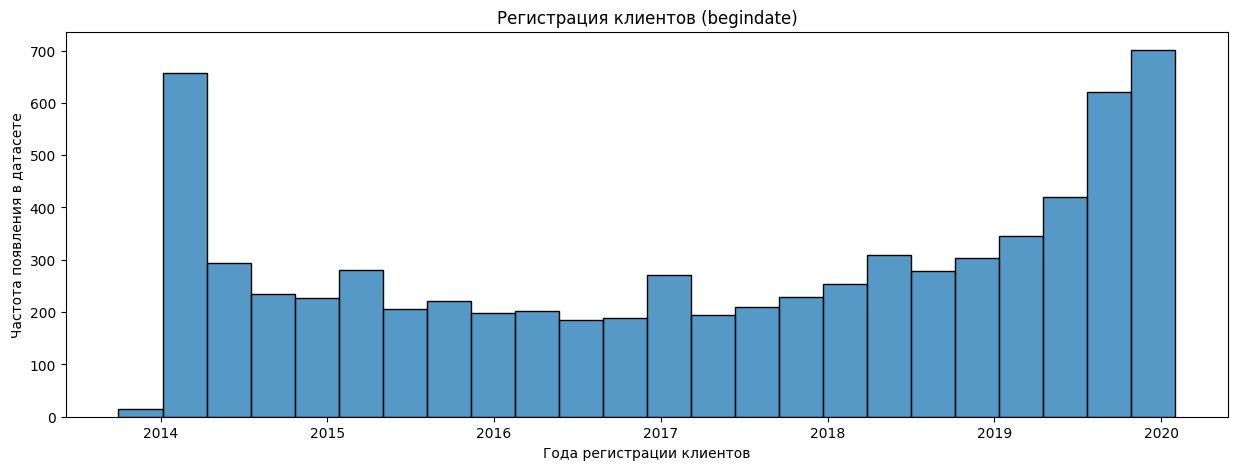

In [22]:
plt.figure(figsize=(15, 5))
sns.histplot(df_telecom['begindate'],
            bins=24)

plt.title('Регистрация клиентов (begindate)')
plt.xlabel('Года регистрации клиентов')
plt.ylabel('Частота появления в датасете')
plt.show()

Наблюдается пик в начале 2014 года, вероятно это связано с полноценным началом работы компании. С 2015 по конец 2018 года - величина привлеченных клиентов стабильна. Начиная с 2019 наблюдается бурный рост количества новых клиентов.

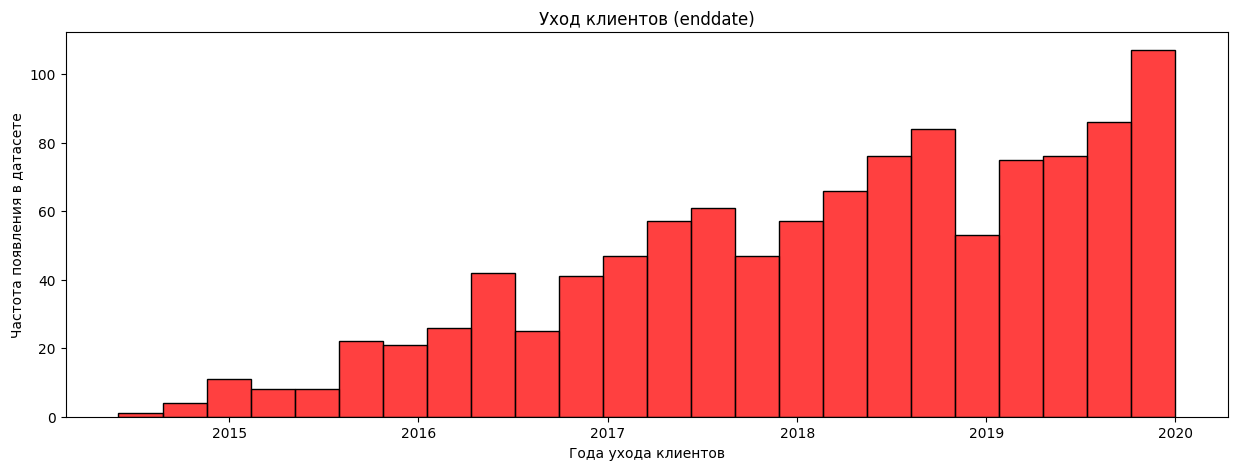

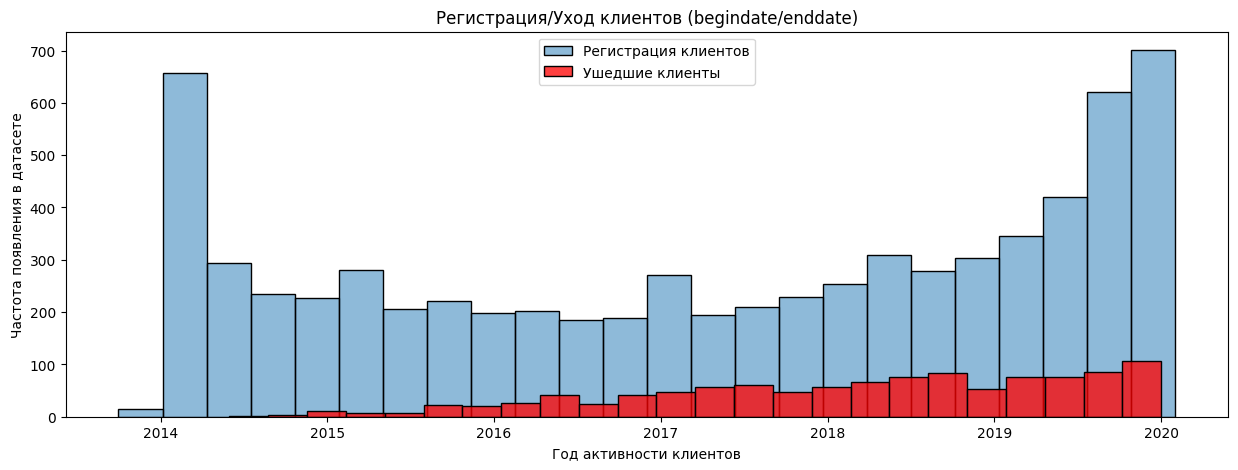

In [23]:
plt.figure(figsize=(15, 5))
df_filtered = df_telecom.query('enddate != "2020-02-01"')# убираем действующих клиентов
sns.histplot(df_filtered['enddate'],
             bins=24, color='r')

plt.title('Уход клиентов (enddate)')
plt.xlabel('Года ухода клиентов')
plt.ylabel('Частота появления в датасете')
plt.show()



plt.figure(figsize=(15, 5))
sns.histplot(df_telecom['begindate'],
            label='Регистрация клиентов', bins=24, alpha=0.5)

df_filtered = df_telecom.query('enddate != "2020-02-01"')# убираем действующих клиентов
sns.histplot(df_filtered['enddate'],
             label='Ушедшие клиенты', color='r', bins=24)

plt.title('Регистрация/Уход клиентов (begindate/enddate)')
plt.xlabel('Год активности клиентов')
plt.ylabel('Частота появления в датасете')
plt.legend()
plt.show()

Со временем число уходящих пользователей стабильно растет, но количество новых клиентов увеличивается значительно быстрее.

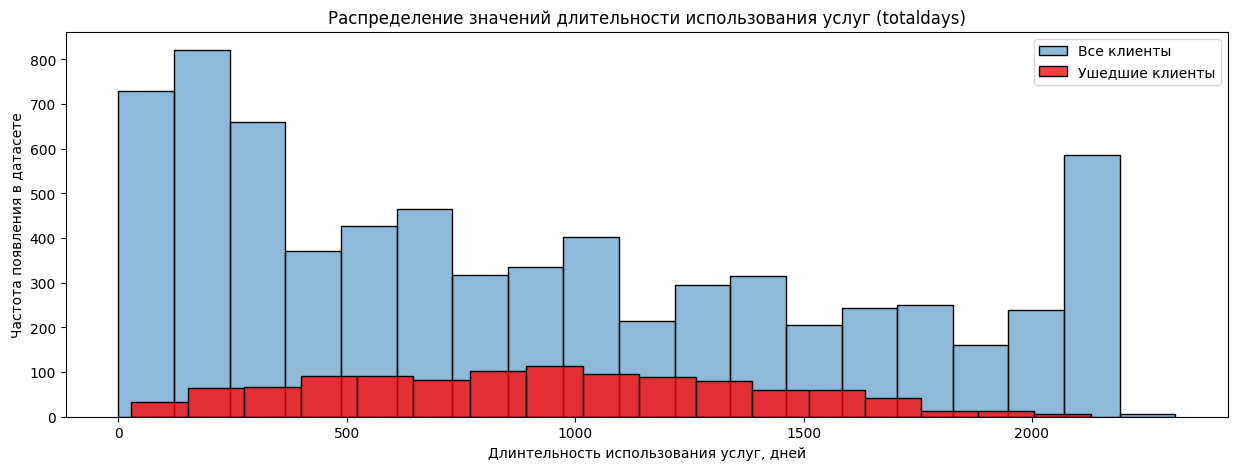

In [24]:
plt.figure(figsize=(15, 5))
sns.histplot(df_telecom['totaldays'],
             alpha=0.5, 
             label='Все клиенты')

sns.histplot(df_telecom.query('escape == 1')['totaldays'],
                  color='r', 
                  label='Ушедшие клиенты')

plt.title('Распределение значений длительности использования услуг (totaldays)')
plt.xlabel('Длинтельность использования услуг, дней')
plt.ylabel('Частота появления в датасете')
plt.legend()
plt.show()

С течением времени количество уходящих клиентов увеличивается, а количество пользователей уменьшается, после 1000 дней частота ухода клиентов стабильно падает

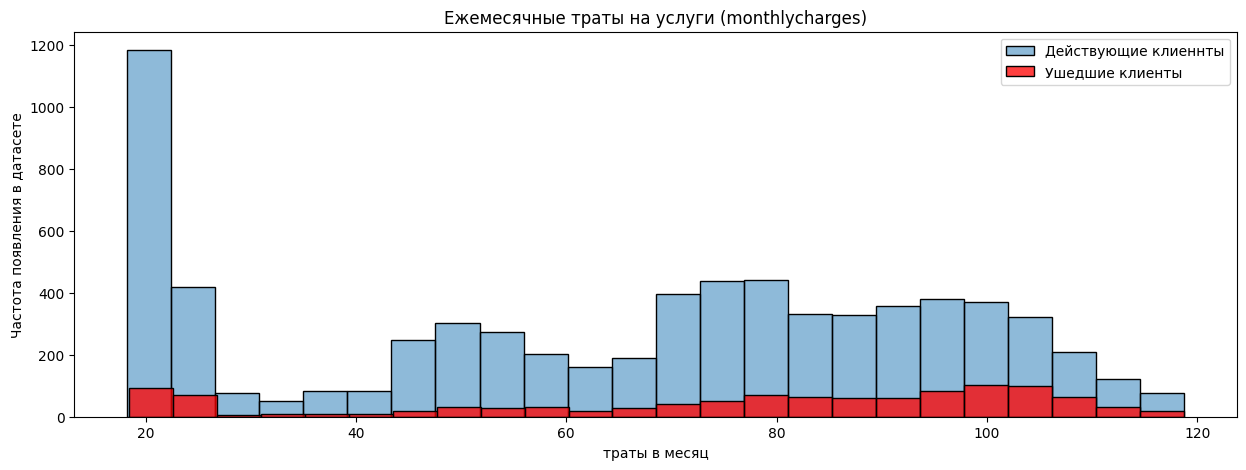

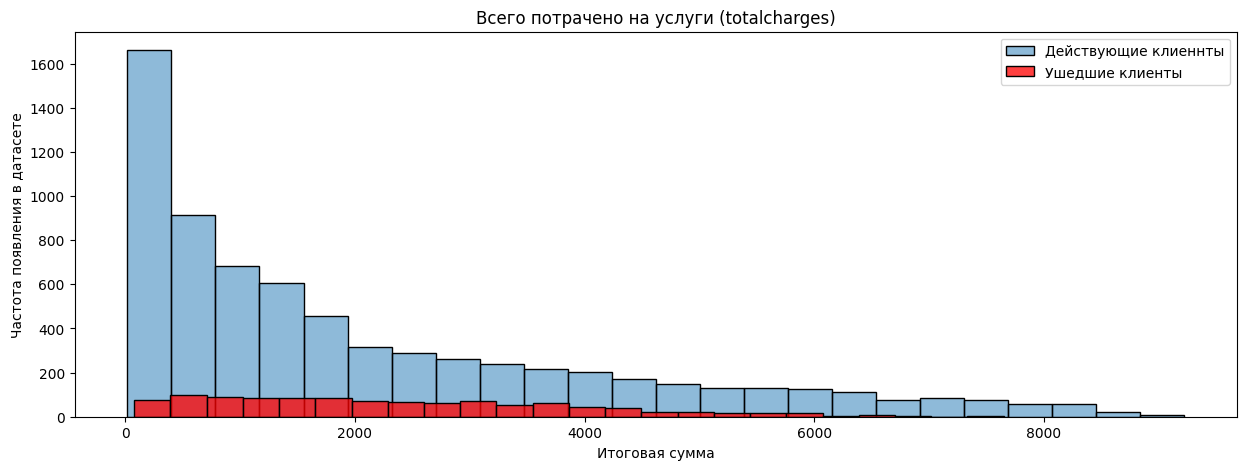

In [25]:
plt.figure(figsize=(15, 5))
sns.histplot(df_telecom['monthlycharges'],
            label='Действующие клиеннты', bins=24, alpha=0.5)

df_filtered = df_telecom.query('enddate != "2020-02-01"')# убираем действующих клиентов
sns.histplot(df_filtered['monthlycharges'],
             label='Ушедшие клиенты', color='r', bins=24)

plt.title('Ежемесячные траты на услуги (monthlycharges)')
plt.xlabel('траты в месяц')
plt.ylabel('Частота появления в датасете')
plt.legend()
plt.show()


plt.figure(figsize=(15, 5))
sns.histplot(df_telecom['totalcharges'],
            label='Действующие клиеннты', bins=24, alpha=0.5)

df_filtered = df_telecom.query('enddate != "2020-02-01"')# убираем действующих клиентов
sns.histplot(df_filtered['totalcharges'],
             label='Ушедшие клиенты', color='r', bins=24)

plt.title('Всего потрачено на услуги (totalcharges)')
plt.xlabel('Итоговая сумма')
plt.ylabel('Частота появления в датасете')
plt.legend()
plt.show()

* На первом графике хороши видны 3 вершины, вполне можно выделить 3 группы пользователей:
    - Использующие "минимальный" тариф (около 20-25)
    - Использующие "средний" тариф (около 50-60)
    - Использующие "дорогой" тариф (около 80+)
* Чаще уходят клиенты "минимального" и "дорогого" тарифа.
* На втором графике видно, что с увеличением общей суммы потраченных денег, вероятность ухода клиента падает.

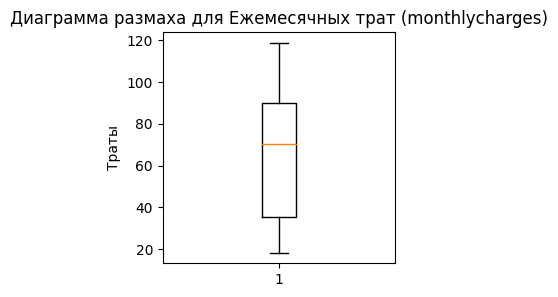

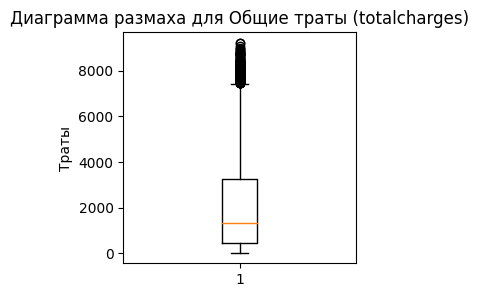

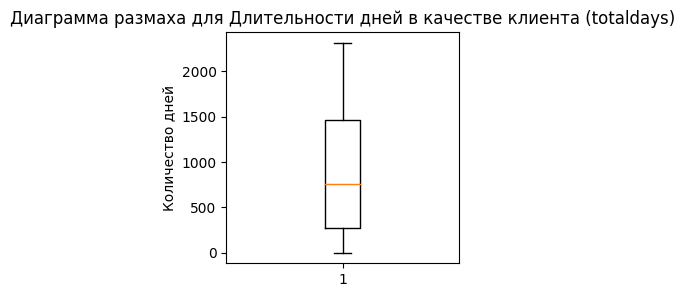

In [26]:
columns = {'monthlycharges': 'Ежемесячных трат (monthlycharges)', 
           'totalcharges': 'Общие траты (totalcharges)', 
           'totaldays': 'Длительности дней в качестве клиента (totaldays)'}

for column in columns:
    plt.figure(figsize=(3, 3))
    plt.boxplot(df_telecom[column])
    plt.title(columns[column])
    plt.ylabel('Траты' if column != 'totaldays' else 'Количество дней')
    plt.title('Диаграмма размаха для ' + columns[column])
    plt.show()

Есть выбросы в `totalcharges`, но они похожи на реальные данные, оставим как есть.

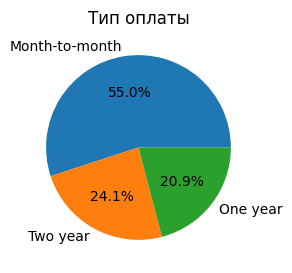

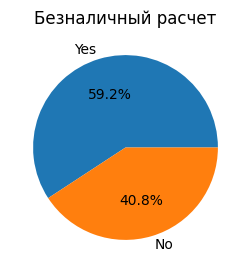

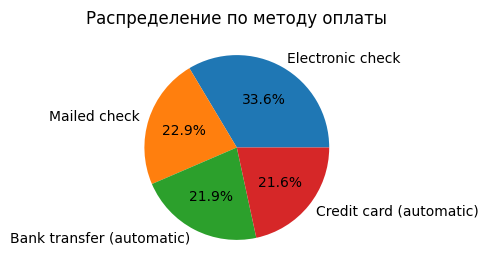

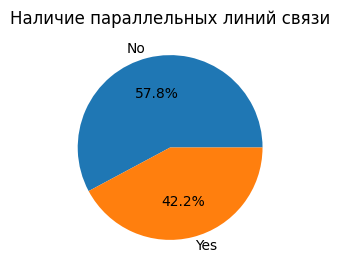

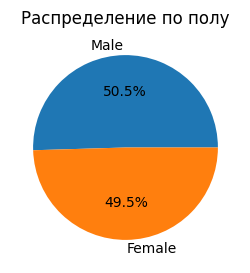

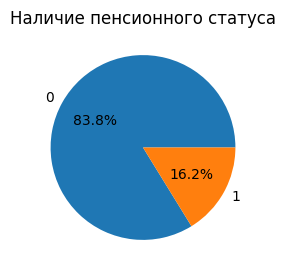

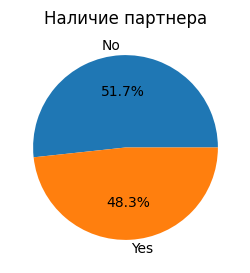

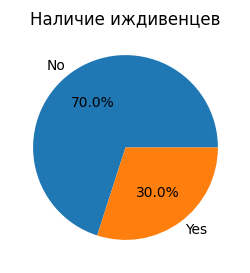

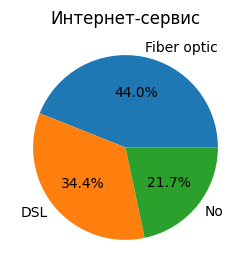

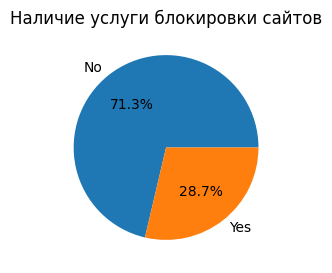

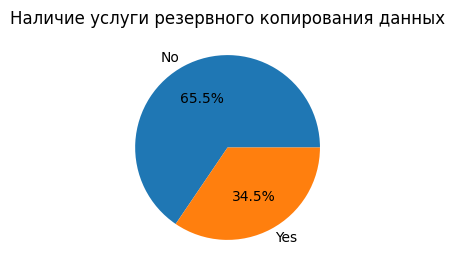

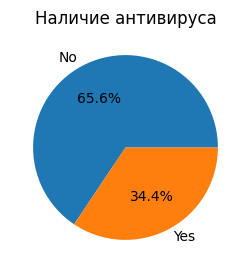

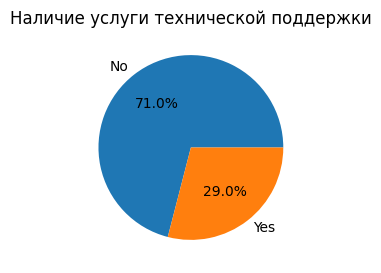

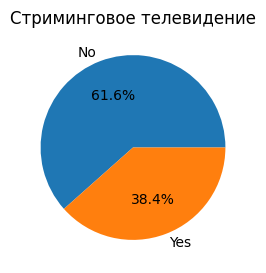

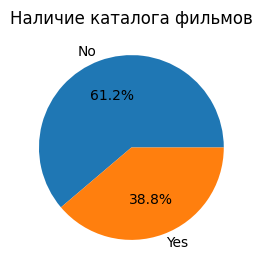

In [27]:
titles = {'deviceprotection': 'Наличие антивируса', 
          'streamingtv': 'Стриминговое телевидение', 
          'streamingmovies': 'Наличие каталога фильмов', 
          'techsupport': 'Наличие услуги технической поддержки', 
          'onlinebackup': 'Наличие услуги резервного копирования данных', 
          'onlinesecurity': 'Наличие услуги блокировки сайтов',
          'internetservice': 'Интернет-сервис', 
          'dependents': 'Наличие иждивенцев', 
          'partner': 'Наличие партнера', 
          'seniorcitizen': 'Наличие пенсионного статуса', 
          'gender': 'Распределение по полу', 
          'multiplelines': 'Наличие параллельных линий связи',
          'paperlessbilling': 'Безналичный расчет',     
          'paymentmethod': 'Распределение по методу оплаты',
          'type':'Тип оплаты'}

for col in df_telecom.columns:
    if col not in ['monthlycharges', 'totalcharges', 'totaldays', 'begindate', 'enddate', 'escape']:
        values = df_telecom[col].value_counts().values
        labels = df_telecom[col].value_counts().index
        plt.figure(figsize=(3, 3))
        plt.pie(values, labels=labels, autopct='%1.1f%%')
        plt.title(titles[col])
        plt.ylabel('')
        plt.show()      

* Предпочитаемый тип оплаты - ежемесячный.
* Чаще люди предпочитают получать и оплачивать счета в электронном виде.
* Услуга `MultipleLines` не пользуются популярностью у пользователей.
* Подключение интернета через оптоволокно более предпочтительно для пользователей, чем через DSL.
* Дополнительные услугу предоставлемые оператором не слишком популярны.
* К стриминговому телевидению и каталогу фильмов есть определенный интерес у пользователей.

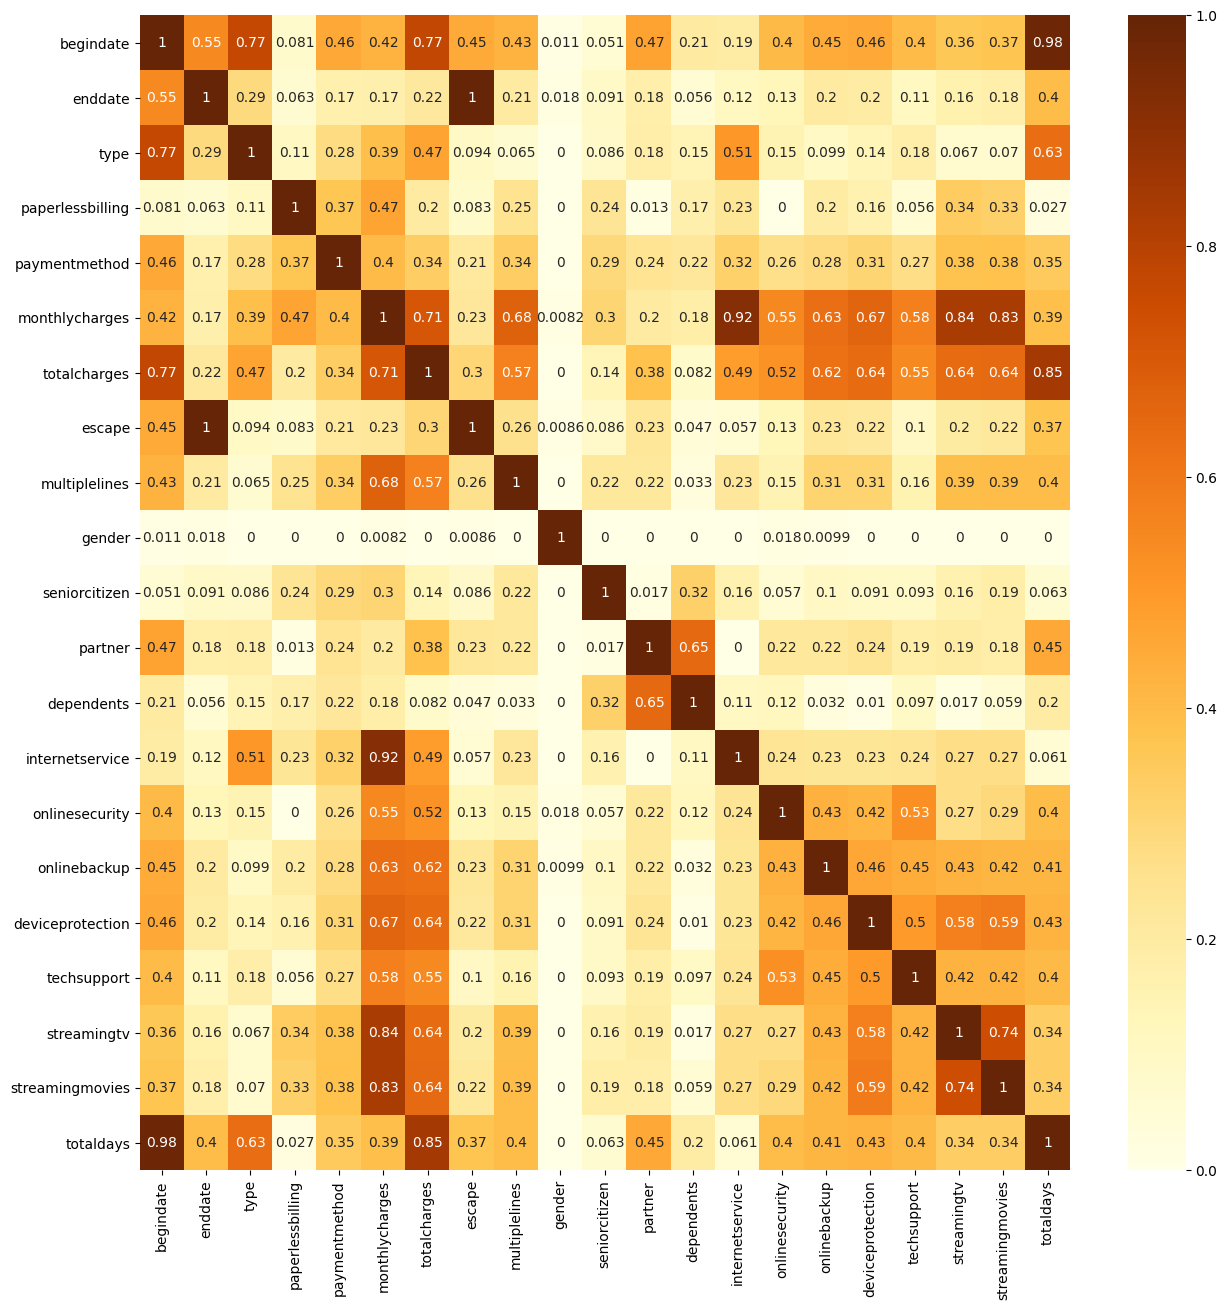

In [28]:
# анализ корреляции
corr_matrix = df_telecom.phik_matrix(interval_cols=['monthlycharges', 'totalcharges', 'totaldays'])

plt.figure(figsize=(15, 15))
sns.heatmap(corr_matrix, annot=True, cmap='YlOrBr');

Можно заметить, что такие признаки как: `internetservice`(тип связи), `dependets`(наличие иждевенцов), `senoircitizen`(пенсионер), `gender`(пол), `type`(тип оплаты), `PaperlessBilling`(безналичный расчет) слабо влияют на решение об уходе клиента. В итоге их можно убрать.

Важный признак `totalcharges` сильно коррелирует с `totaldays`, поэтому его тоже уберем. `streamingmovies` и `streamintv` убираем, они сильно скоррелированы с важным признаком `monthlycharges`.

Расмотрим дисбаланс целевого признака.

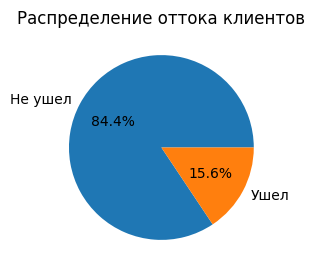

In [29]:
values = df_telecom['escape'].value_counts().values
labels = ['Не ушел', 'Ушел']
plt.figure(figsize=(3, 3))
plt.pie(values, labels=labels, autopct='%1.1f%%')
plt.title("Распределение оттока клиентов")
plt.show()

В целом, наблюдается дисбаланс у целевого признака. Но это реальный отток клиентов, поэтому дополнительных мер для борьбы с дисбалансом применять не будем.

#### Вывод

* Сделан анализ важности и распределения признаков.
* Исследовали корреляцию.
* Оценили дисбаланс классов.

**Так же можно сделать несколько предположений:**

- Несмотря на постепенное увеличение оттока клиентов, количество новых клиентов увеличивается значительно быстрее.
- Чем дольше пользователь является клиентом, тем меньше вероятность его ухода, особенно важный срок 3 года, он является переломным.
- Чаще уходят клиенты тратящие в месяц минимум или наоборот, достаточно много. "Среднечки" дольше задерживаются.
- С увеличением общей суммы потраченных денег, вероятность ухода клиента падает.
- Дополнительные услугу предоставлемые оператором не слишком популярны. Но, к стриминговому телевидению и каталогу фильмов есть определенный интерес у пользователей.

## Обучение моделей

In [30]:
# Убираем лишние столбцы
df_telecom = df_telecom.drop(columns=['totalcharges', 
                                      'begindate', 
                                      'enddate', 
                                      'paperlessbilling', 
                                      'type', 
                                      'gender', 
                                      'seniorcitizen', 
                                      'dependents', 
                                      'internetservice',
                                      'streamingtv',
                                      'streamingmovies'])
df_telecom.info()

<class 'pandas.core.frame.DataFrame'>
Index: 7043 entries, 7590-VHVEG to 3186-AJIEK
Data columns (total 10 columns):
 #   Column            Non-Null Count  Dtype  
---  ------            --------------  -----  
 0   paymentmethod     7043 non-null   object 
 1   monthlycharges    7043 non-null   float64
 2   escape            7043 non-null   int32  
 3   multiplelines     7043 non-null   object 
 4   partner           7043 non-null   object 
 5   onlinesecurity    7043 non-null   object 
 6   onlinebackup      7043 non-null   object 
 7   deviceprotection  7043 non-null   object 
 8   techsupport       7043 non-null   object 
 9   totaldays         7043 non-null   int64  
dtypes: float64(1), int32(1), int64(1), object(7)
memory usage: 835.8+ KB


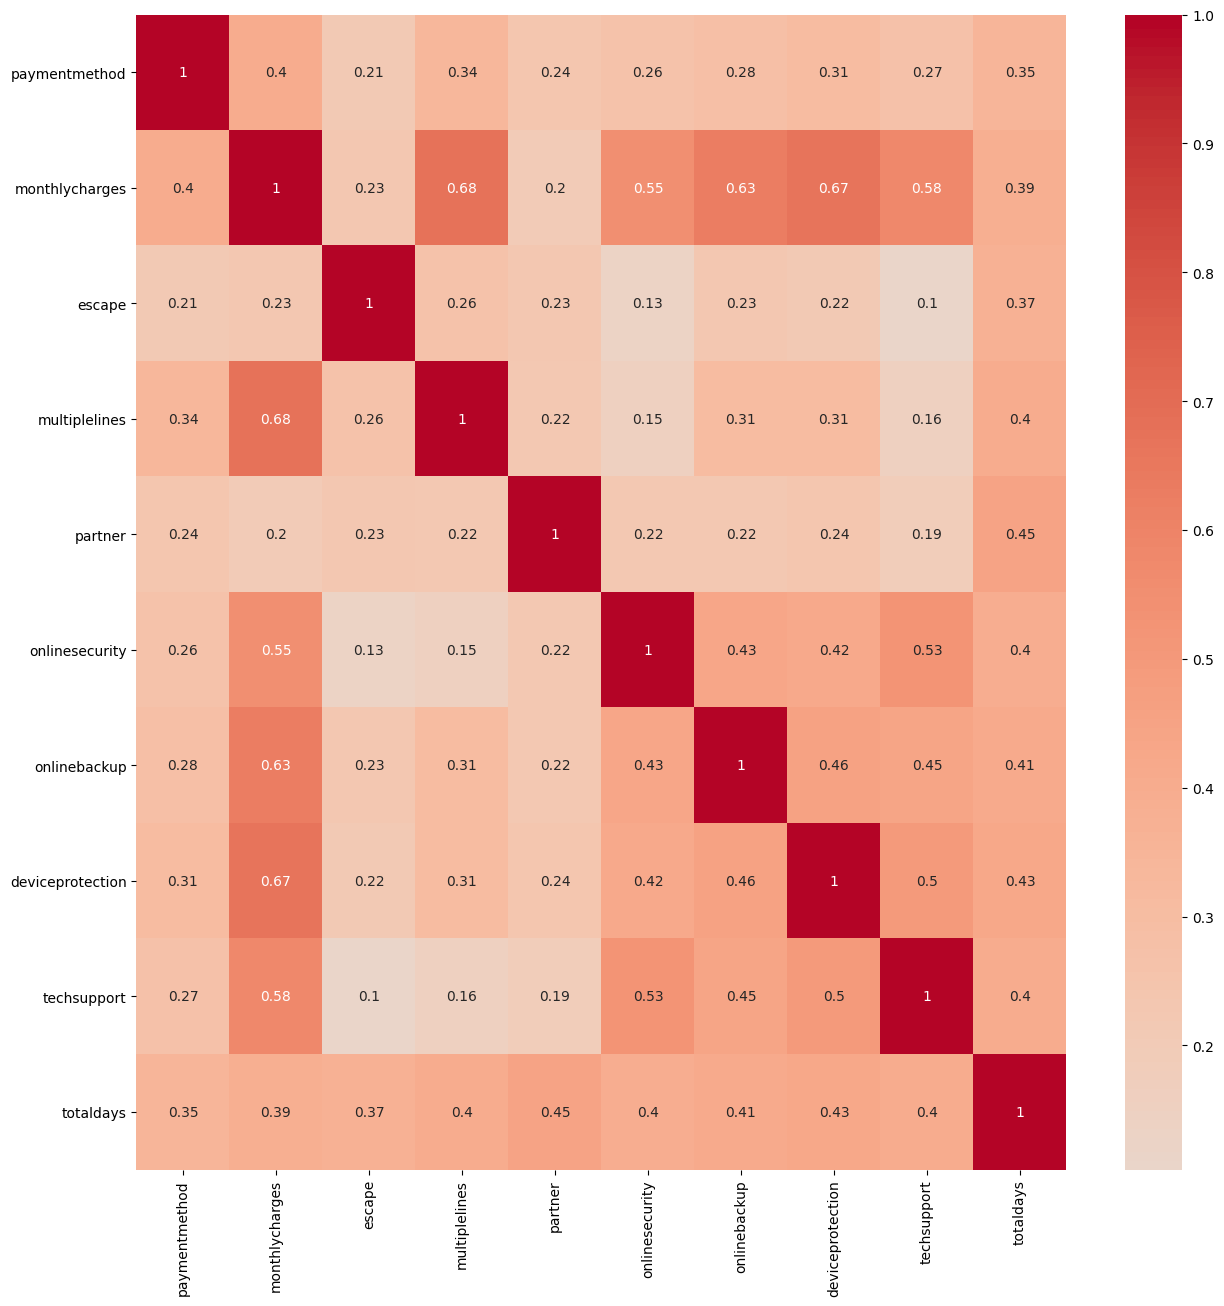

In [31]:
# анализ корреляции
corr_matrix = df_telecom.phik_matrix(interval_cols=['monthlycharges', 'totaldays'])

plt.figure(figsize=(15, 15))
sns.heatmap(corr_matrix, annot=True, cmap='coolwarm', center=0);

In [32]:
features = df_telecom.drop(['escape'], axis=1)
target = df_telecom['escape']

features_train, features_test, target_train, target_test = train_test_split(
    features, target, test_size=0.25, random_state=RANDOM_STATE)
print(features_train.shape)
print(features_test.shape)
print(target_train.shape)

(5282, 9)
(1761, 9)
(5282,)


In [33]:
categorical_columns = df_telecom.select_dtypes(include=['object']).columns

# ColumnTransformer
preprocessor = make_column_transformer(
    (StandardScaler(), ['monthlycharges', 'totaldays']),
    (OneHotEncoder(drop='first', handle_unknown='ignore'), categorical_columns))

### LogisticRegression

In [34]:
model_lr = LogisticRegression(random_state=RANDOM_STATE)

param_grid_lr = {'classifier__C': [0.01, 0.1, 1, 10, 100],
             'classifier__penalty': ['l1', 'l2']}

pipeline_lr = Pipeline([('preprocessor', preprocessor),
                     ('classifier', model_lr)])

grid_search_lr = GridSearchCV(pipeline_lr, param_grid_lr, cv=5, scoring='roc_auc', n_jobs=-1)
grid_search_lr.fit(features_train, target_train)

print("Best parameters: ", grid_search_lr.best_params_)
print("Best cross-validation score: {:.2f}".format(grid_search_lr.best_score_))

Best parameters:  {'classifier__C': 1, 'classifier__penalty': 'l2'}
Best cross-validation score: 0.71


### RandomForestClassifier

In [35]:
model_rf = RandomForestClassifier(random_state=RANDOM_STATE)

param_grid_rf = {'classifier__n_estimators': range(50, 251, 50),
                 'classifier__max_depth': range(2, 15)}

pipeline_rf = Pipeline([('preprocessor', preprocessor),
                     ('classifier', model_rf)])

grid_search_rf = GridSearchCV(pipeline_rf, param_grid_rf, cv=5, scoring='roc_auc', n_jobs=-1)
grid_search_rf.fit(features_train, target_train)

print("Best parameters: ", grid_search_rf.best_params_)
print("Best cross-validation score: {:.2f}".format(grid_search_rf.best_score_))

Best parameters:  {'classifier__max_depth': 7, 'classifier__n_estimators': 250}
Best cross-validation score: 0.82


### CatBoostClassifier

In [36]:
model_cat = CatBoostClassifier(random_state=RANDOM_STATE, verbose=0)

param_grid_cat = {'classifier__max_depth': [5],
                 'classifier__learning_rate': [0.01, 0.1, 1]}

pipeline_cat = Pipeline([('preprocessor', preprocessor),
                     ('classifier', model_cat)])

grid_search_cat = GridSearchCV(pipeline_cat, param_grid_cat, cv=5, scoring='roc_auc', n_jobs=-1)
grid_search_cat.fit(features_train, target_train)

print("Best parameters: ", grid_search_cat.best_params_)
print("Best cross-validation score: {:.2f}".format(grid_search_cat.best_score_))

Best parameters:  {'classifier__learning_rate': 0.1, 'classifier__max_depth': 5}
Best cross-validation score: 0.92


In [37]:
# функция для графика по auc-roc
def auc_roc_plot (model):
    probabilities = model.predict_proba(features_train)
    probabilities_one = probabilities[:, 1]

    fpr, tpr, thresholds=roc_curve(target_train, probabilities_one)
    return fpr, tpr

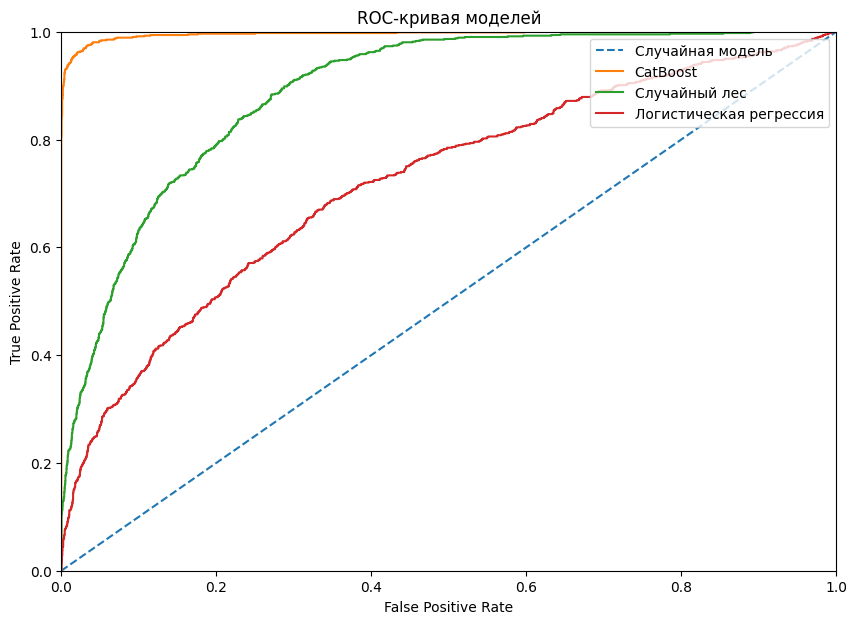

,CatBoostClassifier,RandomForestClassifier,LogisticRegression
Качество моделей (ROC_AUC),0.918342,0.817101,0.714565


In [38]:
plt.figure(figsize=(10,7))
plt.plot([0, 1], [0, 1], linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.0])
list1, list2 = auc_roc_plot(grid_search_cat)
plt.plot(list1, list2)
list1, list2 = auc_roc_plot(grid_search_rf)
plt.plot(list1, list2)
list1, list2 = auc_roc_plot(grid_search_lr)
plt.plot(list1, list2)
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC-кривая моделей')
plt.legend(('Случайная модель','CatBoost','Случайный лес','Логистическая регрессия'),
           loc= 'upper right') 
plt.show()


comparison_tabl = pd.DataFrame(index=['Качество моделей (ROC_AUC)'], columns=['CatBoostClassifier','RandomForestClassifier', "LogisticRegression"])
comparison_tabl['CatBoostClassifier'] = grid_search_cat.best_score_
comparison_tabl['RandomForestClassifier'] = grid_search_rf.best_score_
comparison_tabl['LogisticRegression'] = grid_search_lr.best_score_
comparison_tabl

#### Вывод 
* Исходные данные были разделены на обучающую и тестовую выборки в соотношении 75:25. 
    
* В исходных данных были присутствовали категориальные признаки, которые были закодированы с помощью метода One-Hot Encoding.
    
* Были обучены несколько моделей классификации, `LogisticRegression`, `CatBoostClassifier` и `RandomForestClassifier`.Для каждой модели были подобраны оптимальные гиперпараметры с помощью GridSearchCV.
    
* Модель `CatBoostClassifier` показала лучший резульатат на кросс-валидации. Проведем тест на этой модели.

## Тестирование модели

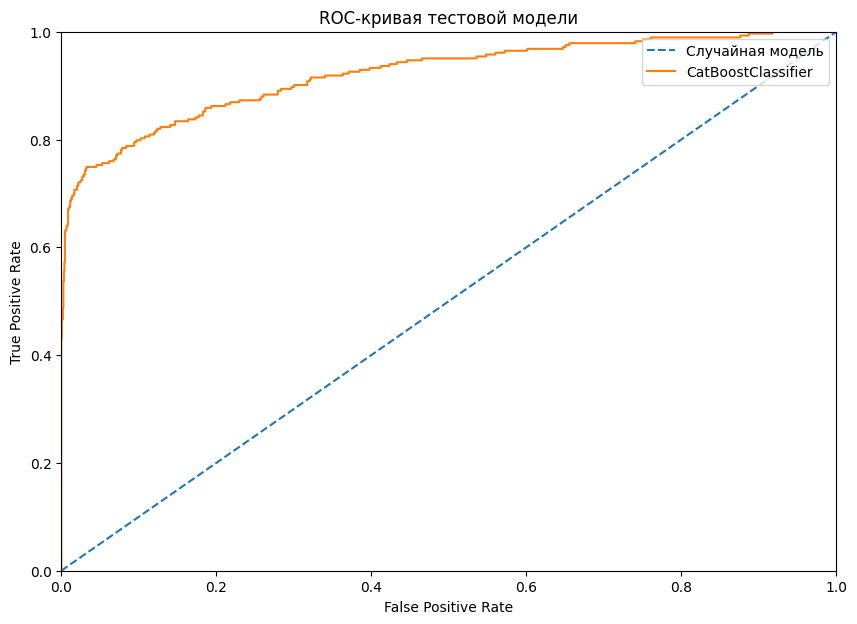

Метрика ROC-кривая: 0.9210146937175154


In [39]:
best_model = grid_search_cat.best_estimator_
probabilities_one = best_model.predict_proba(features_test)[:, 1]
roc_auc = roc_auc_score(target_test, probabilities_one)


plt.figure(figsize=(10,7))
plt.plot([0, 1], [0, 1], linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.0])
fpr, tpr, thresholds = roc_curve(target_test, probabilities_one)
plt.plot(fpr, tpr)
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC-кривая тестовой модели')
plt.legend(('Случайная модель','CatBoostClassifier'),
           loc= 'upper right') 
plt.show()

print("Метрика ROC-кривая:", roc_auc)

Значение метрики `ROC AUC`, равное `0.92`, говорит о том, что модель имеет хорошую способность разделять объекты разных классов. Однако, необходимо помнить, что метрика `ROC_AUC` не учитывает дисбаланс классов и может давать завышенные оценки качества модели.

### Анализ важности признаков

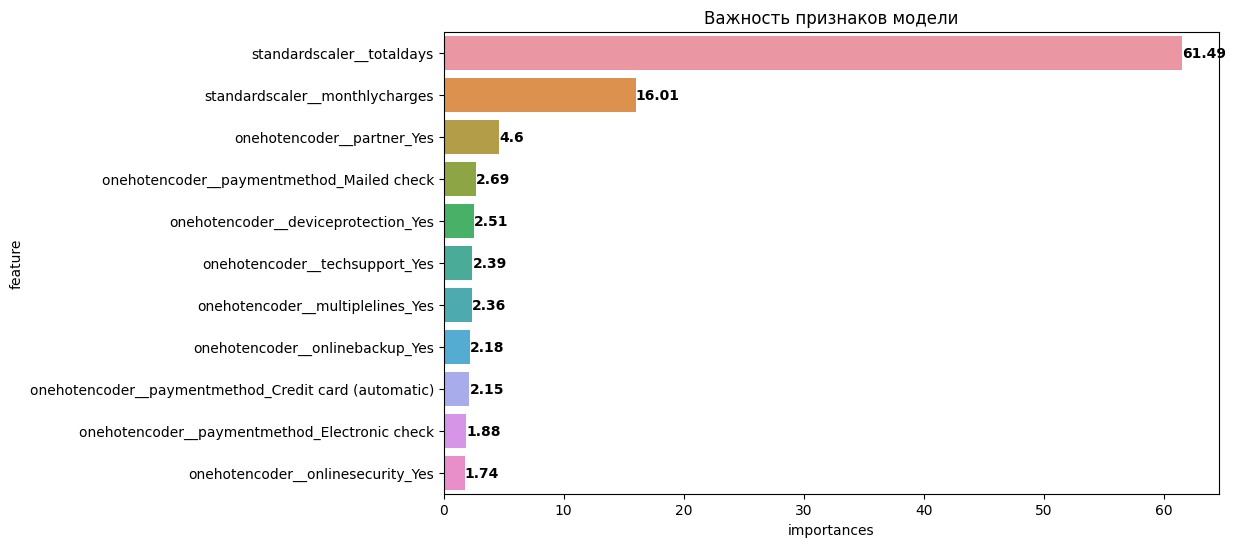

In [40]:
# Анализ важности признаков
importances = best_model.named_steps['classifier'].feature_importances_
feature_names = best_model.named_steps['preprocessor'].get_feature_names_out()

importances_df = pd.DataFrame(list(zip(feature_names, importances)), columns=['feature', 'importances'])
importances_df = importances_df.sort_values(by='importances', ascending=False)

fig, ax = plt.subplots(figsize=(10, 6))
sns.barplot(y=importances_df['feature'], x=importances_df['importances'])
plt.title('Важность признаков модели')

for i, v in enumerate(importances_df['importances']):
    ax.text(v + 0.01, i + 0.1, str(round(v, 2)), color='black', fontweight='bold')

plt.show()

На графике видно, что численные признаки оказывают наибольшие влияние на обучение модели. `totaldays` оказывает большое влияние, `totalcharges` и `monthlycharges` как мы помним, еще и сильно коррелируют, поэтому при обучении модели я убрал `totalcharges`, что улучшило качество модели. Категориальные признаки, оказывают незначительное влияние на обучение.

### Анализ матрицы ошибок

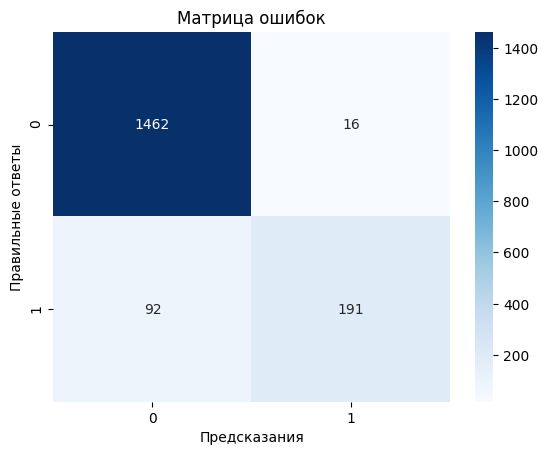

Точность (precision): 0.9227053140096618
Полнота (recall): 0.6749116607773852
F1-мера (F1-score): 0.7795918367346939
Точность (accuracy): 0.938671209540034


In [41]:
pred = best_model.predict(features_test)
cm = confusion_matrix(target_test, pred)

sns.heatmap(cm, annot=True, cmap='Blues', fmt='g')
plt.title('Матрица ошибок')
plt.xlabel('Предсказания')
plt.ylabel('Правильные ответы')
plt.show()

print("Точность (precision):", precision_score(target_test, pred))
print("Полнота (recall):", recall_score(target_test, pred))
print("F1-мера (F1-score):", f1_score(target_test, pred))
print("Точность (accuracy):", accuracy_score(target_test, pred))

Исходя из этой матрицы, можно сделать следующие выводы:

* Модель хорошо работает на классе 0, так как количество правильно предсказанных объектов этого класса (1461) значительно превышает количество неправильно предсказанных объектов класса 0 (17).
* В целом, модель предсказывает правильно 2/3 уходищих клиентов, что уже неплохо. То что она определила false positives (17) не так плохо, это так же поможет удержать клиента.

### Вывод:

* После обучения и оценки качества моделей на кросс-валидации, была выбрана лучшая модель - `CatBoostClassifier`. Для оценки качества модели на тестовой выборке была использована метрика `ROC_AUC`.

* Оценка лучшей модели на тестовой выборке показала `accuracy` на уровне `0.93`, что говорит о том, что модель хорошо работает на новых данных.

* Для анализа важности признаков был использован метод `feature importance`. Было выявлено, что наибольший вклад в классификацию вносят признаки `totaldays`, `totalcharges` и `monthlycharges`.

* Анализ матрицы ошибок показал, что `recall=0.67` при определении класса 1. Модель ошибается, когда относит объекты к классу 1, и пропускает некоторые объекты этого класса. Но в целом, удовлетворяет условию задачи. Можно попытаться увеличить количество этого класса.

## Вывод по итогам работы

В данном проекте была поставлена задача классификации оттока клиентов. Для решения этой задачи были выполнены следующие шаги:

- Описание задачи. Была описана задача и поставлены цели проекта.
- Изучение и подготовка данных. Были загружены данные и проведен предварительный анализ. Были выявлены пропуски в данных и необходимость преобразования категориальных признаков.
- Предобработка данных. Были обработаны пропуски и преобразованы категориальные признаки. Был создан целевой признак и подготовлена итоговая таблица со всеми признаками.
- Анализ данных. Был проведен анализ распределения признаков, исследована корреляция между признаками и оценен дисбаланс классов.
- Обучение моделей. Были сформированы выборки, закодированы категориальные признаки и обучены несколько моделей классификации. Для каждой модели были подобраны оптимальные гиперпараметры с помощью `GridSearchCV`. Была проведена оценка моделей на кросс-валидации.
- Тестирование модели. Была оценена лучшая модель на тестовой выборке, проведен анализ важности признаков и матрицы ошибок.
- Вывод по итогам работы. В результате исследования была выбрана лучшая модель - `CatBoostClassifier` с использованием `One-Hot Encoding`. Модель показала `ROC_AUC` на уровне `0.92`. Это выше порогового значения в `0.85`, значит задачу можно считать выполненной.😁

<div style="background: linear-gradient(to bottom, #ffffff, #f2f2f2);
            border: 1px solid #ccc;
            box-shadow: 0 0 10px rgba(0,0,0,0.3);
            padding: 20px;
            border-radius: 10px;">

# Отчет по проекту

### Описание задачи
В данном проекте мы решали задачу бинарной классификации для определения ухода клиента из телекоммуникационной компании. Наша задача заключалась в том, чтобы построить модель, которая сможет предсказывать, уйдет ли клиент из компании в ближайшее время или останется.

### Шаги работы над проектом:

1) Изучение данных и их предобработка.
- Провели анализ данных, обнаружили пропущенные значения и заменили их средним значением.
- Создали дополнительный признак **`totaldays`** - количество дней пользования услугами компании.
- Создали новый столбец **`escape`** и обнаружили дисбаланс классов в целевом признаке, где **`84%`** клиентов остались в компании, а **`16%`** ушли. 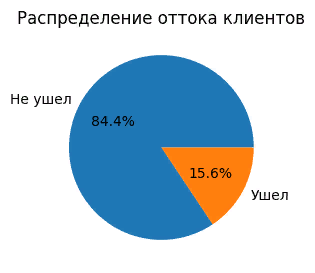 
- По итогам предобработки объединили все признаки в одну таблицу и удалили ненужные.

2) Обучение моделей.
- Обучили несколько моделей, включая **`LogisticRegression`**, **`RandomForestClassifier`** и **`CatBoostClassifier`**.
- При оценки качества моделей использовали метрику **`ROC-AUC`** на кросс-валидации и на тестовой выборке.
| Модель | ROC-AUC |
|--------|---------|
| LogisticRegression | 0.714 | 
| RandomForestClassifier | 0.817 |
| CatBoostClassifier | 0.918 | 

3) Тестирование модели.
- Выбрали лучшую модель **`CatBoostClassifier`** с лучшим результатом. Оценили лучшую модель на тестовой выборке.

| Модель | ROC-AUC | ROC-AUC на тесте | Accuracy на тесте |
|--------|---------|----------|----------|
| CatBoostClassifier | 0.918 | 0.921 | 0.938 |

- Анализ матрицы ошибок и выявил, что модель предсказывает правильно **`2/3`** уходящих клиентов.
- Провели анализ важности признаков и выявили наиболее важные признаки для прогнозирования оттока клиентов, а именно:
    * `totaldays` - количество дней пользования услугами компании.
    * `monthlycharges` - ежемесячные траты на услуги.
    
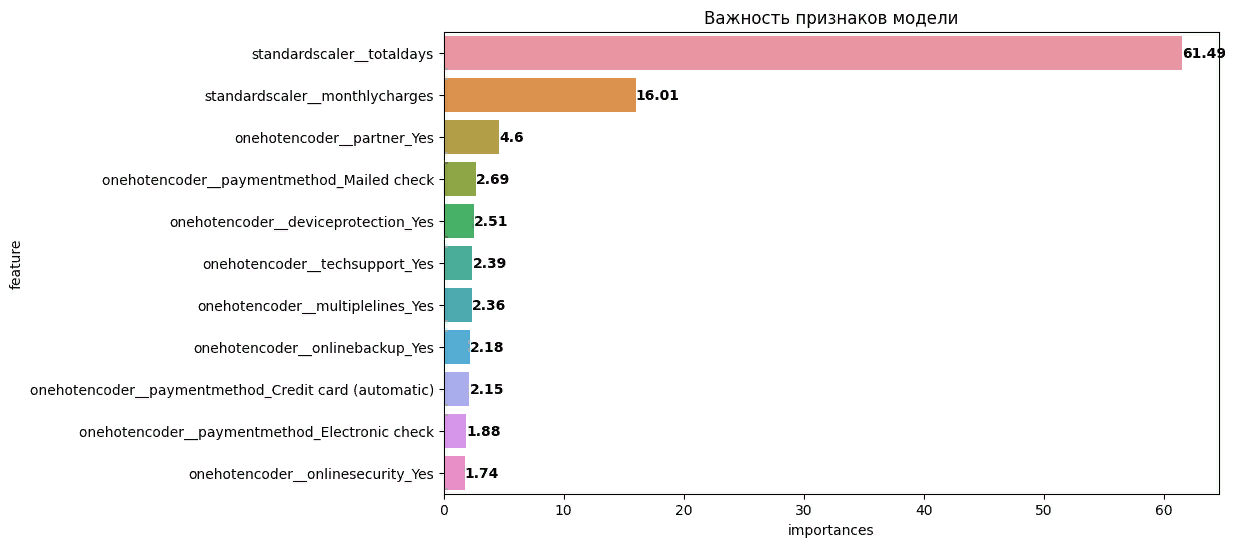

#### Итоговый список признаков для обучения модели:
    
- `totaldays` - количество дней пользования услугами компании (численный признак);
- `monthlycharges` - ежемесячные траты на услуги (численный признак);
- `partner` - наличие партнера (бинарный признак);
- `tech_support` - наличие услуги технической поддержки (бинарный признак);
- `online_backup` - наличие услуги резервного копирования данных (бинарный признак);
- `multiple_lines` - наличие нескольких линий связи (бинарный признак);
- `online_security` - наличие услуги блокировки сайтов (бинарный признак);
- `device_protection` - наличие антивируса (бинарный признак);
- `payment_method` - метод оплаты (категориальный признак).

Для обработки данных использовали методы кодирования категориальных признаков (**`One-Hot Encoding`**) и стандартизации числовых признаков (**`StandardScaler`**).
    

**Соответствие плана фактической работе** - В целом, работа над проектом шла по плану. Однако, были некоторые отклонения, связанные с обработкой данных.

- Например, встречалась ***мультиколлинеарность*** признаков, что могло привести к переобучению модели. Решение этой проблемы потребовало дополнительного анализа и удаления наиболее скоррелированных признаков. 

- Также мы столкнулись с проблемой ***дисбаланса*** классов в целевом признаке. Было решено не трогать этот дисбаланс, но можно попробовать использовать различные методы балансировки классов, такие как взвешивание классов, увеличение выборки минорного класса и уменьшение выборки мажорного класса.

- Также были некоторые трудности с обучением нескольких моделей для определения лучшей. Мы решили эту проблему путем использования **`Pipeline`** для обработки данных и построения модели. Он позволил автоматизировать процесс обработки данных и построения модели, что упростило работу и позволило быстрее получить результаты.

    
**Итоговая модель** - **`CatBoostClassifier`** с метрикой **`ROC-AUC`** на кросс-валидации **`0.921`** и **`Accuracy`** **`0.938`** на тестовой выборке. Гиперпараметры модели были подобраны с помощью **`GridSearchCV`**.

| Модель | Гиперпараметры | ROC-AUC на тесте | Accuracy на тесте |
|----------------------|-------------------------------|-----------------|-------------------|
| CatBoostClassifier | learning_rate=0.1, max_depth=5 | 0.921 | 0.938 |
 

**По итогам работы** мы успешно решили поставленную задачу и построили модель, которая может предсказывать, уйдет ли клиент из компании в ближайшее время или останется. Мы выявили наиболее важные признаки для прогнозирования оттока клиентов и определили лучшую модель для решения задачи. Это позволит компании принимать меры по удержанию клиентов и улучшению качества услуг.
     </div>